# Vocabulary Size를 변경해서 시도해보기

지금까지는 모델을 변경하고, 모델을 조합해서 성능을 올리는 일에 힘썼다. 그런데 어쩌면 성능을 높이는 방법은 단순히 모델을 조정하는 일에 한정되지 않을 수 있다. 데이터의 전처리는 모델의 성능에 영향을 직접적으로 준다. 특히나 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있다. 중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있다. 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있기에 단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트를 해보자.

## 사용할 라이브러리  버전 확인

In [1]:
import tensorflow
import matplotlib
import seaborn 
import numpy 
import pandas
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.6.0
3.4.3
0.11.2
1.21.4
1.3.3
1.0


In [2]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import reuters


# 1. 모든 단어 사용

## 훈련 데이터와 테스트 데이터 로드하기
로이터 뉴스 데이터를 훈련 데이터와 테스트 데이터로 나누어 변수에 각각 저장한다. num_words는 이 데이터에서 빈도수 기준으로 상위 몇 번째 단어까지 사용할 것인지 조절한다. 모든 단어를 사용하기 위해 None으로 지정해준다. 각 단어는 고유한 번호가 정해져 있는 상태이고, 이를 통해서 사용할 단어의 수를 정한다. test_split = 0.2는 전체 데이터 중에서 80%를 훈련 데이터, 20%를 테스트 데이터로 사용한다는 의미이다. x_train과 x_test는 훈련용 뉴스 데이터와 테스트용 뉴스 데이터, y_train과 y_test는 훈련용 뉴스 데이터의 레이블와 테스트용 뉴스 데이터의 레이블이 된다.

In [3]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [4]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


## 데이터 출력해보기
훈련용 뉴스는 8,982개. 그리고 테스트용 뉴스는 2,246개가 있다. 8:2의 비율을 가지는데, 첫 번째 훈련용 뉴스와 첫 번째 테스트용 뉴스를 출력해 본다. 이미 뉴스 데이터를 다운로드할 때는 단어가 아니라 해당 번호로 변환이 되어서 출력된다. 대부분의 자연어 처리에서는 텍스트를 숫자로 수치화하는 과정이 필요한데, 텐서플로우 데이터셋에서는 이미 전처리를 한 데이터를 제공되어 있다.

In [5]:
print(x_train[0])
print(x_test[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 23406, 28185, 5, 192,

첫 번째 훈련용 뉴스와 테스트용 뉴스의 레이블을 출력해보자.

In [6]:
print(y_train[0])
print(y_test[0])

3
3


둘 다 숫자 3이 출력된다. 각 뉴스는 정수로 된 레이블을 가지고 있다. 이 레이블은 숫자 0부터 시작되므로, 모든 레이블 중 최댓값을 구하고 1을 더하면 현재 클래스의 개수를 볼 수 있다.

In [7]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


## 데이터 분포 확인해보기

자연어 처리 과정에서 문장과 문서들의 길이는 보통 다르다. 우리가 평소에 보는 뉴스 기사의 길이가 항상 똑같지는 않듯이 이 데이터도 똑같다. 모든 뉴스 데이터들은 길이가 다 다를 것이다. 뉴스 데이터의 길이 분포를 확인해보자.

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


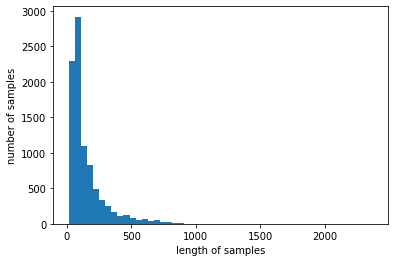

In [8]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

길이가 가장 긴 뉴스의 길이는 2,376이고 평균 길이는 145이다. 아무래도 길이가 가장 긴 뉴스의 길이가 다른 뉴스에 비해 유독 긴 편인 것 같다. 시각화된 그래프의 분포로 봤을 때 500~1,000 사이의 길이를 가지는 뉴스도 일부 있어 보인다. 
우리가 맞춰야 하는 클래스의 분포를 확인해보자. 모델의 성능에 영향을 줄 수 있는 요소이기 때문에 실제로 모든 클래스가 다 존재는 하는 것인지, 또 어떤 클래스가 유독 많은지와 같은 것들을 사전에 확인해 보아야 한다.

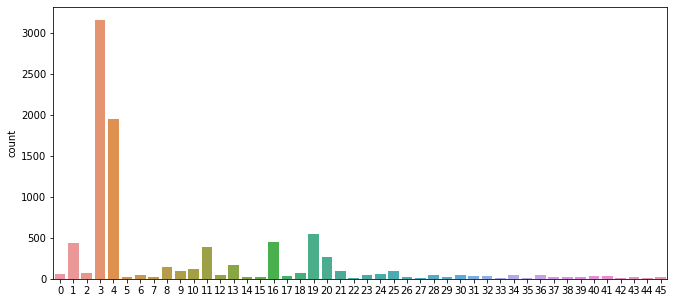

In [9]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

이 뉴스 데이터는 3번, 4번 클래스가 대부분을 차지하고 있다. 그 뒤로는 19번, 16번, 1번, 11번 등이 높은 분포를 가지고 있다. 시각화를 통해 어떤 클래스가 많고, 적은 것을 쉽게 확인할 수는 있었지만 수치적으로 정확히 몇 개인지도 출력해보자.

In [10]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


3번, 4번 클래스의 경우에는 각각 3,159개와 1,949개가 존재한다. 그 뒤로는 549개로 19번 클래스가 세 번째로 많고, 16번 클래스가 444개로 네 번째로 많다. 이렇게 각 클래스가 몇 개가 존재하는지도 확인했다.

## 원본 뉴스 데이터로 복원해보기
이 데이터는 이미 어느 정도 전처리가 되어서 각 단어가 정수 시퀀스로 변환된 채 제공되고 있다고 언급했었지만 일반적인 상황이라면 텍스트를 숫자로 수치화하는 과정을 처음부터 해야 한다.
그래서 우리는 여기서 정수 시퀀스로 변환된 데이터를 '굳이' 다시 텍스트로 돌려볼 것이다.
로이터 뉴스 데이터는 '단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary를 제공한다. 이를 word_index로 저장해보자.

In [11]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

이게 이 데이터의 단어장(Vocabulary) 이다. 이제 word_index 안에 단어를 입력하면 이 단어가 어떤 정수와 맵핑이 되는지를 알 수 있다. 단어 'the'는 어떤 정수와 맵핑이 될 지 확인해보자

In [12]:
word_index['the']

1

뉴스 데이터 안에서 단어 'the'는 사실 1번이 아니라 4번 단어이다. 왜냐하면 0번, 1번, 2번은 사실 자연어 처리에 쓰이는 특별한 토큰들을 위해 맵핑된 번호이기 때문이다. (각각 , , 라는 토큰을 나타낸다.)
그렇기 때문에, 다른 단어들도 word_index의 결과로 나오는 숫자에 3을 더해주어야 단어가 실제로 맵핑된 인덱스 값이 나온다. 이건 로이터 뉴스 데이터가 정의한 일종의 약속이다.


In [13]:
index_to_word = { index+3 : word for word, index in word_index.items() }
print(index_to_word[4])

the


위에서 0번, 1번, 2번 인덱스에는 각각 <pad>, <sos>, <unk>라는 특별한 토큰이 맵핑되어 있다고 했었다. 그래서 만들어진 index_to_word에 이 토큰들도 추가해주어야 진짜 index_to_word가 완성된다.

In [14]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

index_to_word를 통해서 첫 번째 훈련용 뉴스 기사를 원래 텍스트로 복원해보자.

In [15]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


## OOV 문제와 UNK 토큰
기계가 알고 있는 단어들의 집합을 단어장(Vocabulary)이라고 한다. 기계가 미처 배우지 못한 모르는 단어를 OOV(Out-Of-Vocabulary) 또는 UNK(Unknown) 이라고 표현한다. 어떤 단어를 기계가 모르는 단어로 판단하면, 기계는 해당 단어를 전부 <unk>라는 일관된 특별 토큰으로 변환한다. 만약 num_words=10000는 정수 번호가 10,000이 넘는 단어들을 자동으로 <unk> 토큰으로 처리한다.로이터 뉴스 데이터에서 <unk>은 정수 2번을 가지도록 약속돼 있으므로 데이터를 로드하는 과정에서 정수 번호가 10,000이 넘는 단어들은 전부 정수 2로 변환되어서 로드가 되었던 것이다. 하지만 지금은 num_words=None으로 모든 단어를 사용하기로 했기 때문에 넘어간다.

이제 전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환해 보자.

In [16]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [17]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


각각 5개씩 출력해보고, 제대로 변환이 되었는지 확인해 보자.

In [18]:
x_train[:5]

['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3",
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect th

In [19]:
x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman arsenio yulo said yu

## 벡터화 하기

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import accuracy_score, f1_score

Document Term Matrix, DTM은 사이킷런의 CountVectorizer()를 통해서 생성할 수 있다.
DTM을 생성하고, DTM의 크기를 확인해보자.

In [21]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


훈련용 뉴스의 수가 총 8982개였기 때문에 DTM의 행의 개수는 8982개가 된다. 모든 단어를 사용하기로 했기에 26506이라는 큰 값이 나온다. 다시 말하자면 훈련 데이터셋에 있는 8982개의 문장을 사용하며 모든 단어인 26506개의 단어들이 사용된다.
DTM 행렬을 이어서 TF-IDF 행렬을 만들어보자. 

In [22]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


## 나이브 베이즈 분류기

나이브 베이즈 분류기는 사이킷런의 MultinomialNB()를 통해 사용할 수 있다.

사이킷런이 제공하는 머신러닝 모델들은 공통적으로 fit()이라는 함수를 제공하고 있는데 훈련 데이터와 해당 훈련 데이터에 대한 레이블을 인자로 사용하면 모델이 이를 학습한다.

In [26]:
#model = MultinomialNB()
#model.fit(tfidfv, y_train)

테스트 데이터에 대한 정확도를 측정하기 위해서는 훈련 데이터와 동일한 전처리를 거쳐야 한다. 다시 말해 테스트 데이터도 TF-IDF 행렬로 변환해 주어야 한다. 그 후 해당 행렬과 predict() 함수를 통해 예측값을 얻어 정확도를 측정한다.

In [27]:
#x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
#tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

#predicted_nb = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
#f1_nb = f1_score(y_test, predicted, average='weighted')  # average='weighted'는 각 클래스의 샘플 수로 가중 평균을 계산 지정
#print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
#print("F1 점수:", f1)

## Complement Naive Bayes Classifier(CNB)

In [28]:
#cb = ComplementNB()
#cb.fit(tfidfv, y_train)

In [29]:
#predicted_cb = cb.predict(tfidfv_test)
#f1_cb = f1_score(y_test, predicted, average='weighted')
#print("정확도:", accuracy_score(y_test, predicted))
#print("F1 점수:", f1)

#predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
#print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

## 로지스틱 회귀(Logistic Regression)

In [30]:
#lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=0)
#lr.fit(tfidfv, y_train)

In [31]:
#predicted_lr = lr.predict(tfidfv_test)
#f1_lr = f1_score(y_test, predicted, average='weighted')
#print("정확도:", accuracy_score(y_test, predicted))
#print("F1 점수:", f1)

## 선형 서포트 벡터 머신(Linear Support Vector Machine)

In [32]:
#lsvc = LogisticRegression(penalty='l2', max_iter=1000, random_state=0)
#lsvc.fit(tfidfv, y_train)

In [33]:
#predicted_lsvc = lsvc.predict(tfidfv_test)
#f1_lsvc = f1_score(y_test, predicted, average='weighted')  
#print("정확도:", accuracy_score(y_test, predicted))
#print("F1 점수:", f1)

## 결정 트리(Decision Tree)

In [34]:
#tree = DecisionTreeClassifier(max_depth=10, random_state=0)
#tree.fit(tfidfv, y_train)

In [35]:
#predicted_tree = tree.predict(tfidfv_test)
#f1_tree = f1_score(y_test, predicted, average='weighted') 
#print("정확도:", accuracy_score(y_test, predicted))
#print("F1 점수:", f1)

## 랜덤 포레스트(Random Forest)

In [36]:
#forest = RandomForestClassifier(n_estimators=5, random_state=0)
#forest.fit(tfidfv, y_train)

In [37]:
#predicted_forest = forest.predict(tfidfv_test)
#f1_forest = f1_score(y_test, predicted, average='weighted') 
#print("정확도:", accuracy_score(y_test, predicted))
#print("F1 점수:", f1)

## 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [38]:
# 15분 정도 소요될 수 있습니다.
#grbt = GradientBoostingClassifier(random_state=0) # verbose=3
#grbt.fit(tfidfv, y_train)

In [39]:
#predicted_grbt = grbt.predict(tfidfv_test)
#f1_grbt = f1_score(y_test, predicted, average='weighted')  
#print("정확도:", accuracy_score(y_test, predicted))
#print("F1 점수:", f1)

## 보팅(Voting)

무슨 이유에서인진 몰라도 제일 높은 점수가 나왔던 LinearSVC를 사용하고 싶었지만 지속적인 에러가 생겼다. LinearSVC를 사용하고 있기 때문에 probability=True 옵션을 직접 사용할 수 없으며 LinearSVC의 경우 predict_proba 메서드를 직접 제공하지 않고 따라서 VotingClassifier의 soft 투표 방식에서는 LinearSVC를 사용할 수 없다고 한다.. 이 부분은 좀 더 공부가 필요할 거 같다.

In [37]:
#lsvc = LinearSVC(C=10000, penalty='l1', max_iter=1000, dual=False)
#logistic = LogisticRegression(penalty='l2', max_iter=1000, random_state=0)
#gradient_boosting = GradientBoostingClassifier()

# VotingClassifier 객체 생성 (voting은 'soft'로 설정)
#voting_classifier = VotingClassifier(estimators=[
#    ('lr', logistic), 
#    ('gb', gradient_boosting),
#    ('lsvc', lsvc)],
#    voting='soft')

# 모델 훈련
#voting_classifier.fit(tfidfv, y_train)

In [40]:
# 로지스틱 회귀, Complement Naive Bayes, GradientBoosting Classifier 객체 생성
#logistic = LogisticRegression(penalty='l2', max_iter=10000, random_state=0)
#complement_nb = ComplementNB()
#gradient_boosting = GradientBoostingClassifier()

# VotingClassifier 객체 생성 (voting은 'soft'로 설정)
#voting_classifier = VotingClassifier(estimators=[
#    ('lr', logistic), 
#    ('cnb', complement_nb), 
#    ('gb', gradient_boosting)], 
#    voting='soft')

# 모델 훈련
#voting_classifier.fit(tfidfv, y_train)

In [41]:
#predicted_voting = voting_classifier.predict(tfidfv_test)
#f1_voting = f1_score(y_test, predicted, average='weighted')  
#print("정확도:", accuracy_score(y_test, predicted))
#print("F1 점수:", f1)

노드대로 8개의 모델들을 각각 따로 학습시켜보려 했으나 시간이 너무 오래걸리고 복잡해져서 for문으로 모델들을 학습시켰다. 전체적인 코드는 위에와 동일하다.

In [23]:
from sklearn.metrics import accuracy_score, f1_score

# 모델 초기화 및 학습
models = [
    MultinomialNB(),
    ComplementNB(),
    LogisticRegression(C=10000, penalty='l2', max_iter=3000),
    LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False),
    DecisionTreeClassifier(max_depth=10, random_state=0),
    RandomForestClassifier(n_estimators=5, random_state=0),
    GradientBoostingClassifier(random_state=0)
]

model_names = [
    'MultinomialNB',
    'ComplementNB',
    'LogisticRegression',
    'LinearSVC',
    'DecisionTree',
    'RandomForest',
    'GradientBoosting'
]

# Voting Classifier
voting_classifier = VotingClassifier(estimators=[
    ('lr', LogisticRegression(penalty='l2', max_iter=10000, random_state=0)),
    ('cnb', ComplementNB()),
    ('gb', GradientBoostingClassifier())
], voting='soft')
models.append(voting_classifier)
model_names.append('VotingClassifier')

# 각 모델을 학습하고 평가
accuracies = []
f1_scores = []

for model, name in zip(models, model_names):
    model.fit(tfidfv, y_train)
    y_pred = model.predict(tfidfv)
    
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred, average='macro') # average='macro'각 클래스에 대한 F1 점수의 단순 평균
    
    accuracies.append(accuracy)
    f1_scores.append(f1)
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("-" * 50)

MultinomialNB:
  Accuracy: 0.6346
  F1 Score: 0.0816
--------------------------------------------------
ComplementNB:
  Accuracy: 0.8403
  F1 Score: 0.6831
--------------------------------------------------
LogisticRegression:
  Accuracy: 0.9684
  F1 Score: 0.9656
--------------------------------------------------


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC:
  Accuracy: 0.9684
  F1 Score: 0.9653
--------------------------------------------------
DecisionTree:
  Accuracy: 0.6807
  F1 Score: 0.2586
--------------------------------------------------
RandomForest:
  Accuracy: 0.9423
  F1 Score: 0.9197
--------------------------------------------------
GradientBoosting:
  Accuracy: 0.9482
  F1 Score: 0.9548
--------------------------------------------------
VotingClassifier:
  Accuracy: 0.9397
  F1 Score: 0.9420
--------------------------------------------------


Accuracy는 LogisticRegression과 LinearSVC 두 모델이 똑같이 96.84%로 제일 높게 나왔으며 F1 score는 LogisticRegression이 96.56%로 제일 높게 나왔다. MNB모델의 F1 score가 8.16%으로 너무나 처참한 결과가 나왔는데 이게 맞는 건가 싶다..

8개의 모델들의 시각화한 결과이다. 

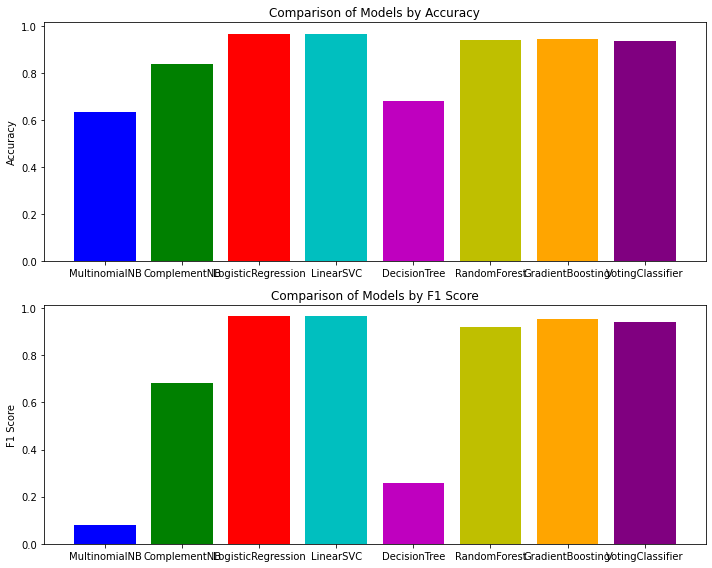

In [25]:
# 그래프 그리기
plt.figure(figsize=(10, 8))

# Accuracy 그래프
plt.subplot(2, 1, 1)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple']
plt.bar(model_names, accuracies, color=colors)
plt.ylabel('Accuracy')
plt.title('Comparison of Models by Accuracy')

# F1 점수 그래프
plt.subplot(2, 1, 2)
plt.bar(model_names, f1_scores, color=colors)
plt.ylabel('F1 Score')
plt.title('Comparison of Models by F1 Score')

plt.tight_layout()
plt.show()

# 2. 빈도수 상위 5,000개의 단어만 사용

위에서 했던 과정을 빠르게 진행하고 비교해본다.

In [42]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [43]:
word_index = reuters.get_word_index(path="reuters_word_index1.json")

565248/550378 [==============================] - 0s 0us/step


In [44]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [45]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [46]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [47]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


제대로 변환이 되었는지 확인해봤다. 아까는 없던 'unk'가 들어가 있고 잘 변환된거 같다!

In [48]:
x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> <unk> said <unk> told reuters a survey during the curr

위에 과정과 동일하게 진행한다. 훈련 데이터셋에 있는 8982개의 문장을 사용하며 4867개의 고유한 단어가 사용된다.

In [49]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 4867)


In [50]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 4867)


In [51]:
from sklearn.metrics import accuracy_score, f1_score

# 모델 초기화 및 학습
models = [
    MultinomialNB(),
    ComplementNB(),
    LogisticRegression(C=10000, penalty='l2', max_iter=3000),
    LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False),
    DecisionTreeClassifier(max_depth=10, random_state=0),
    RandomForestClassifier(n_estimators=5, random_state=0),
    GradientBoostingClassifier(random_state=0)
]

model_names = [
    'MultinomialNB',
    'ComplementNB',
    'LogisticRegression',
    'LinearSVC',
    'DecisionTree',
    'RandomForest',
    'GradientBoosting'
]

# Voting Classifier
voting_classifier = VotingClassifier(estimators=[
    ('lr', LogisticRegression(penalty='l2', max_iter=10000, random_state=0)),
    ('cnb', ComplementNB()),
    ('gb', GradientBoostingClassifier())
], voting='soft')
models.append(voting_classifier)
model_names.append('VotingClassifier')

# 각 모델을 학습하고 평가
accuracies = []
f1_scores = []

for model, name in zip(models, model_names):
    model.fit(tfidfv, y_train)
    y_pred = model.predict(tfidfv)
    
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred, average='macro') # average='macro'각 클래스에 대한 F1 점수의 단순 평균
    
    accuracies.append(accuracy)
    f1_scores.append(f1)
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("-" * 50)

MultinomialNB:
  Accuracy: 0.7011
  F1 Score: 0.1334
--------------------------------------------------
ComplementNB:
  Accuracy: 0.8111
  F1 Score: 0.5980
--------------------------------------------------
LogisticRegression:
  Accuracy: 0.9684
  F1 Score: 0.9654
--------------------------------------------------


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC:
  Accuracy: 0.9684
  F1 Score: 0.9657
--------------------------------------------------
DecisionTree:
  Accuracy: 0.6774
  F1 Score: 0.2677
--------------------------------------------------
RandomForest:
  Accuracy: 0.9453
  F1 Score: 0.9201
--------------------------------------------------
GradientBoosting:
  Accuracy: 0.9410
  F1 Score: 0.9508
--------------------------------------------------
VotingClassifier:
  Accuracy: 0.9333
  F1 Score: 0.9407
--------------------------------------------------


Accuracy는 위에서 모든 단어로 학습을 시켰던것과 마찬가지로 LogisticRegression과 LinearSVC 두 모델이 똑같이 96.84%로 제일 높게 나왔으며 F1 score는 LinearSVC가 96.57%로 제일 높게 나왔다. 

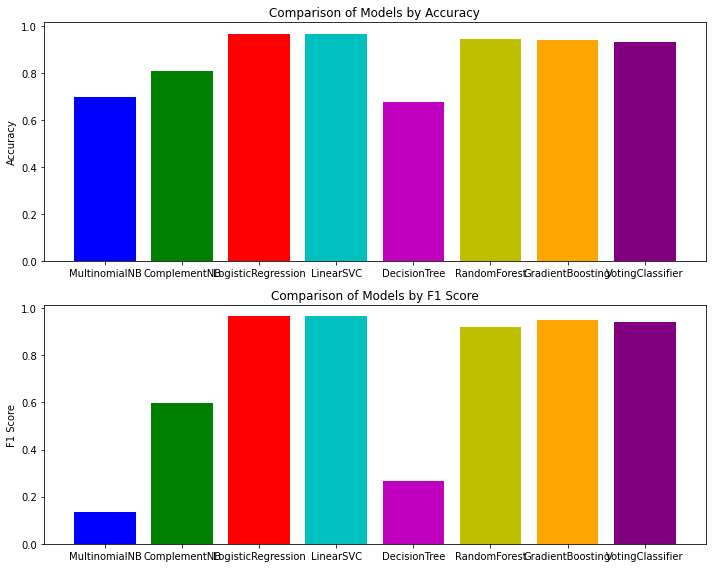

In [52]:
# 그래프 그리기
plt.figure(figsize=(10, 8))

# Accuracy 그래프
plt.subplot(2, 1, 1)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple']
plt.bar(model_names, accuracies, color=colors)
plt.ylabel('Accuracy')
plt.title('Comparison of Models by Accuracy')

# F1 점수 그래프
plt.subplot(2, 1, 2)
plt.bar(model_names, f1_scores, color=colors)
plt.ylabel('F1 Score')
plt.title('Comparison of Models by F1 Score')

plt.tight_layout()
plt.show()

# 3. 빈도수 상위 1,000개의 단어만 사용

위에서 했던 과정을 빠르게 진행하고 비교해본다.

In [53]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

In [54]:
word_index = reuters.get_word_index(path="reuters_word_index2.json")

565248/550378 [==============================] - 0s 0us/step


In [55]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [56]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [57]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [58]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


위에 과정과 동일하게 진행되며 훈련 데이터셋에 있는 8982개의 문장을 사용하며 969개의 고유한 단어가 사용된다.

In [59]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 969)


In [60]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 969)


In [61]:
# 모델 초기화 및 학습
models = [
    MultinomialNB(),
    ComplementNB(),
    LogisticRegression(C=10000, penalty='l2', max_iter=3000),
    LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False),
    DecisionTreeClassifier(max_depth=10, random_state=0),
    RandomForestClassifier(n_estimators=5, random_state=0),
    GradientBoostingClassifier(random_state=0)
]

model_names = [
    'MultinomialNB',
    'ComplementNB',
    'LogisticRegression',
    'LinearSVC',
    'DecisionTree',
    'RandomForest',
    'GradientBoosting'
]

# Voting Classifier
voting_classifier = VotingClassifier(estimators=[
    ('lr', LogisticRegression(penalty='l2', max_iter=10000, random_state=0)),
    ('cnb', ComplementNB()),
    ('gb', GradientBoostingClassifier())
], voting='soft')
models.append(voting_classifier)
model_names.append('VotingClassifier')

# 각 모델을 학습하고 평가
accuracies = []
f1_scores = []

for model, name in zip(models, model_names):
    model.fit(tfidfv, y_train)
    y_pred = model.predict(tfidfv)
    
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred, average='macro') # average='macro'각 클래스에 대한 F1 점수의 단순 평균
    
    accuracies.append(accuracy)
    f1_scores.append(f1)
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("-" * 50)

MultinomialNB:
  Accuracy: 0.7111
  F1 Score: 0.1911
--------------------------------------------------
ComplementNB:
  Accuracy: 0.7607
  F1 Score: 0.3284
--------------------------------------------------
LogisticRegression:
  Accuracy: 0.9684
  F1 Score: 0.9658
--------------------------------------------------


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC:
  Accuracy: 0.9637
  F1 Score: 0.9645
--------------------------------------------------
DecisionTree:
  Accuracy: 0.6794
  F1 Score: 0.2267
--------------------------------------------------
RandomForest:
  Accuracy: 0.9459
  F1 Score: 0.9275
--------------------------------------------------
GradientBoosting:
  Accuracy: 0.9292
  F1 Score: 0.9219
--------------------------------------------------
VotingClassifier:
  Accuracy: 0.9222
  F1 Score: 0.9170
--------------------------------------------------


Accuracy는 LogisticRegression이 96.84%로 제일 높게 나왔으며 F1 score 역시 LogisticRegression이 96.58%로 제일 높게 나왔다.

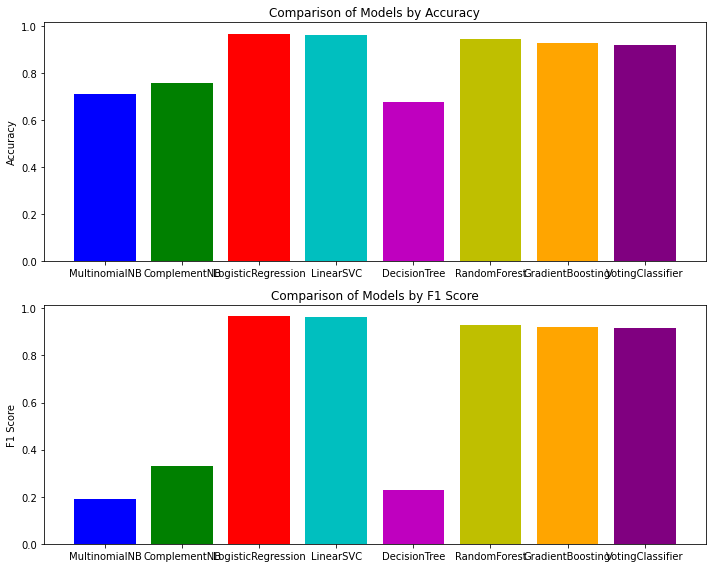

In [62]:
# 그래프 그리기
plt.figure(figsize=(10, 8))

# Accuracy 그래프
plt.subplot(2, 1, 1)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple']
plt.bar(model_names, accuracies, color=colors)
plt.ylabel('Accuracy')
plt.title('Comparison of Models by Accuracy')

# F1 점수 그래프
plt.subplot(2, 1, 2)
plt.bar(model_names, f1_scores, color=colors)
plt.ylabel('F1 Score')
plt.title('Comparison of Models by F1 Score')

plt.tight_layout()
plt.show()

# 4. 딥러닝 모델과 비교해 보기

데이터를 로드해주고 위와 똑같이 토큰화를 시켜주고 텍스트 변환하여 DTM생성하고 TF-IDF 변환 후 패딩을 해주고 RNN 모델을 만들었다.

In [241]:
# 데이터 로드
(x_train, y_train), (x_val, y_val) = reuters.load_data(num_words=1000, test_split=0.2)
num_classes = max(y_train) + 1

In [242]:
# word_index 및 index_to_word 설정
word_index = reuters.get_word_index()
index_to_word = {index + 3: word for word, index in word_index.items()}

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

In [243]:
# 텍스트로 변환
decoded_train = [' '.join(index_to_word[index] for index in x_train[i]) for i in range(len(x_train))]
decoded_val = [' '.join(index_to_word[index] for index in x_val[i]) for i in range(len(x_val))]

In [244]:
# DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(decoded_train)
x_val_dtm = dtmvector.transform(decoded_val)

In [245]:
# TF-IDF 변환
tfidf_transformer = TfidfTransformer()
tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)
tfidfv_val = tfidf_transformer.transform(x_val_dtm)

In [246]:
# RNN 입력을 위한 패딩
X_train_pad = pad_sequences(x_train, max_len)
X_val_pad = pad_sequences(x_val, max_len)
print(X_train_pad)

[[  0   0   0 ...  15  17  12]
 [  0   0   0 ... 505  17  12]
 [132  15  39 ...  11  17  12]
 ...
 [  0   0   0 ... 407  17  12]
 [ 89  39  46 ... 364  17  12]
 [  2 790   2 ... 113  17  12]]


In [247]:
# RNN 모델 구성
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 3, output_dim=64, input_shape=(None,)))  # input_dim 설정 변경
model.add(LSTM(128))
model.add(Dense(64))
model.add(Dense(num_classes, activation='softmax'))  # 2진 분류
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 64)          1982848   
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_36 (Dense)             (None, 46)                2990      
Total params: 2,092,910
Trainable params: 2,092,910
Non-trainable params: 0
_________________________________________________________________


In [248]:
# 모델 컴파일 및 학습
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=20, batch_size=64)

# 검증 세트에서 모델 평가
val_loss, val_acc = model.evaluate(X_val_pad, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/20
141/141 [==============================] - 3s 11ms/step - loss: 2.3947 - accuracy: 0.3923 - val_loss: 1.9500 - val_accuracy: 0.4942
Epoch 2/20
141/141 [==============================] - 1s 8ms/step - loss: 1.8075 - accuracy: 0.5195 - val_loss: 1.8039 - val_accuracy: 0.5361
Epoch 3/20
141/141 [==============================] - 1s 8ms/step - loss: 1.7134 - accuracy: 0.5524 - val_loss: 1.7433 - val_accuracy: 0.5472
Epoch 4/20
141/141 [==============================] - 1s 8ms/step - loss: 1.6840 - accuracy: 0.5579 - val_loss: 1.6859 - val_accuracy: 0.5614
Epoch 5/20
141/141 [==============================] - 1s 8ms/step - loss: 1.5341 - accuracy: 0.6002 - val_loss: 1.5728 - val_accuracy: 0.5971
Epoch 6/20
141/141 [==============================] - 1s 8ms/step - loss: 1.4111 - accuracy: 0.6323 - val_loss: 1.4927 - val_accuracy: 0.6269
Epoch 7/20
141/141 [==============================] - 1s 8ms/step - loss: 1.3038 - accuracy: 0.6622 - val_loss: 1.3957 - val_accuracy: 0.6478
Epoch

Validation Accuracy가 68.66%로 그렇게 좋지 못한 결과인 것 같다. 혹시나 데이터 양이 많아서 그럴 수도 있으니 최대 길이를 잘라주고 훈련 시켜보았다.

In [ ]:
# 데이터 로드
(x_train, y_train), (x_val, y_val) = reuters.load_data(num_words=1000, test_split=0.2)
num_classes = max(y_train) + 1

In [ ]:
# word_index 및 index_to_word 설정
word_index = reuters.get_word_index()
index_to_word = {index + 3: word for word, index in word_index.items()}

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


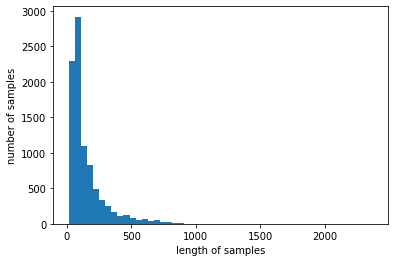

In [250]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

최대길이 max_len을 90으로 설정하여 샘플 길이를 잘라주었다.

In [254]:
max_len = 90
x_train = [s[:max_len] for s in x_train]

최대 길이 :90
평균 길이 :74.0359608105099


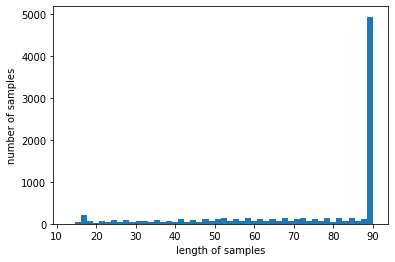

In [255]:
print('최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [234]:
# 텍스트로 변환
decoded_train = [' '.join(index_to_word[index] for index in x_train[i]) for i in range(len(x_train))]
decoded_val = [' '.join(index_to_word[index] for index in x_val[i]) for i in range(len(x_val))]

In [235]:
# DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(decoded_train)
x_val_dtm = dtmvector.transform(decoded_val)

In [236]:
# TF-IDF 변환
tfidf_transformer = TfidfTransformer()
tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)
tfidfv_val = tfidf_transformer.transform(x_val_dtm)

In [237]:
# RNN 입력을 위한 패딩
X_train_pad = pad_sequences(x_train, max_len)
X_val_pad = pad_sequences(x_val, max_len)
print(X_train_pad)

[[  0   0   0 ...  15  17  12]
 [  0   0   0 ... 505  17  12]
 [  1  53  12 ...  92 617  80]
 ...
 [  0   0   0 ... 407  17  12]
 [  1  53  46 ...   9  42  92]
 [  1 227   2 ...  24 286   2]]


In [238]:
# RNN 모델 구성
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 3, output_dim=64, input_shape=(None,)))  # input_dim 설정 변경
model.add(LSTM(128))
model.add(Dense(64))
model.add(Dense(num_classes, activation='softmax'))  # 2진 분류
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 64)          1982848   
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_32 (Dense)             (None, 46)                2990      
Total params: 2,092,910
Trainable params: 2,092,910
Non-trainable params: 0
_________________________________________________________________


In [239]:
# 모델 컴파일 및 학습
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=20, batch_size=64)

# 검증 세트에서 모델 평가
val_loss, val_acc = model.evaluate(X_val_pad, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/20
141/141 [==============================] - 3s 11ms/step - loss: 2.3687 - accuracy: 0.3946 - val_loss: 2.4217 - val_accuracy: 0.4622
Epoch 2/20
141/141 [==============================] - 1s 8ms/step - loss: 1.9238 - accuracy: 0.5024 - val_loss: 1.8495 - val_accuracy: 0.5370
Epoch 3/20
141/141 [==============================] - 1s 8ms/step - loss: 1.7809 - accuracy: 0.5331 - val_loss: 1.7800 - val_accuracy: 0.5472
Epoch 4/20
141/141 [==============================] - 1s 8ms/step - loss: 1.6232 - accuracy: 0.5861 - val_loss: 1.7314 - val_accuracy: 0.5663
Epoch 5/20
141/141 [==============================] - 1s 8ms/step - loss: 1.6142 - accuracy: 0.5689 - val_loss: 1.9579 - val_accuracy: 0.4479
Epoch 6/20
141/141 [==============================] - 1s 8ms/step - loss: 1.5373 - accuracy: 0.5989 - val_loss: 1.6601 - val_accuracy: 0.5686
Epoch 7/20
141/141 [==============================] - 1s 8ms/step - loss: 1.3581 - accuracy: 0.6432 - val_loss: 1.5698 - val_accuracy: 0.6069
Epoch

이것도.. 그렇게 결과가 좋지 못한 것 같다.. 단어 수를 None으로 모든 단어를 학습시켜보자. 과정은 똑같다!

In [260]:
# 데이터 로드
(x_train, y_train), (x_val, y_val) = reuters.load_data(num_words=None, test_split=0.2)
num_classes = max(y_train) + 1

In [261]:
# word_index 및 index_to_word 설정
word_index = reuters.get_word_index()
index_to_word = {index + 3: word for word, index in word_index.items()}

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

In [262]:
max_len = 90
x_train = [s[:max_len] for s in x_train]

In [263]:
# 텍스트로 변환
decoded_train = [' '.join(index_to_word[index] for index in x_train[i]) for i in range(len(x_train))]
decoded_val = [' '.join(index_to_word[index] for index in x_val[i]) for i in range(len(x_val))]

In [264]:
# DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(decoded_train)
x_val_dtm = dtmvector.transform(decoded_val)

In [265]:
# TF-IDF 변환
tfidf_transformer = TfidfTransformer()
tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)
tfidfv_val = tfidf_transformer.transform(x_val_dtm)

In [267]:
# RNN 입력을 위한 패딩
X_train_pad = pad_sequences(x_train, max_len)
X_val_pad = pad_sequences(x_val, max_len)

In [268]:
# RNN 모델 구성
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 3, output_dim=64, input_shape=(None,)))  # input_dim 설정 변경
model.add(LSTM(128))
model.add(Dense(64))
model.add(Dense(num_classes, activation='softmax'))  # 2진 분류
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 64)          1982848   
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 46)                2990      
Total params: 2,092,910
Trainable params: 2,092,910
Non-trainable params: 0
_________________________________________________________________


In [269]:
# 모델 컴파일 및 학습
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=20, batch_size=64)

# 검증 세트에서 모델 평가
val_loss, val_acc = model.evaluate(X_val_pad, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Epoch 1/20
141/141 [==============================] - 3s 10ms/step - loss: 2.2412 - accuracy: 0.4330 - val_loss: 1.9149 - val_accuracy: 0.5080
Epoch 2/20
141/141 [==============================] - 1s 8ms/step - loss: 1.6600 - accuracy: 0.5610 - val_loss: 1.7393 - val_accuracy: 0.5378
Epoch 3/20
141/141 [==============================] - 1s 8ms/step - loss: 1.4754 - accuracy: 0.6032 - val_loss: 1.9205 - val_accuracy: 0.5027
Epoch 4/20
141/141 [==============================] - 1s 8ms/step - loss: 1.3582 - accuracy: 0.6049 - val_loss: 1.6078 - val_accuracy: 0.5833
Epoch 5/20
141/141 [==============================] - 1s 8ms/step - loss: 1.1976 - accuracy: 0.6814 - val_loss: 1.6436 - val_accuracy: 0.6077
Epoch 6/20
141/141 [==============================] - 1s 8ms/step - loss: 0.9701 - accuracy: 0.7367 - val_loss: 1.5660 - val_accuracy: 0.6251
Epoch 7/20
141/141 [==============================] - 1s 8ms/step - loss: 0.8412 - accuracy: 0.7680 - val_loss: 1.5466 - val_accuracy: 0.6229
Epoch

음.. 오히려 모든 단어를 사용해서 그런지 1000개를 적용했을 때보다 Validation Accuracy가 떨어졌다. 결과적으로는 머신러닝이 좋았다!

# 회고

뉴스 기사를 토큰화를 시켜주고 텍스트 변환하여 DTM 생성하고 TF-IDF 변환하여 MultinomialNB, ComplementNB, LogisticRegression, LinearSVC, DecisionTree, RandomForest, 그리고 GradientBoosting 8가지의 모델들로 다양하게 학습해보며 좀 더 전처리를 사용하는 방법에 대해 익숙해질 수 있었던 것 같다. RNN모델을 만들면서 문제가 지속적으로 생겨서 해결하는데에 시간이 많이 소요됐으며 머신러닝 전처리 과정과 마찬가지로 딥러닝도 그대로 사용해도 되는건지 의문이 생겼었다. 또한 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있으며 중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우에도 오히려 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있다는 것을 이번 기회에 알게 되었다. 사실은 크게 다른 결과는 아닌거 같지만.. 아마 RNN모델을 잘못 만들었거나 전처리 과정에서 더 추가적인 게 필요했을 수도 있었을 거 같다. 조금 더 자세하게 공부할 필요성을 느꼈다. 
